In [257]:
import albumentations as A
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
import cv2
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch

In [258]:
os.listdir("../input/famous-iconic-women/output/train/Junko Tabei")[:2]

['000050.jpg', '000038.jpg']

In [259]:
class ImageFolder(Dataset):
    def __init__(self, root_dir, transform=None, total_classes=None):
        self.transform = transform
        self.data = []
        
        if total_classes:
            self.classnames  = os.listdir(root_dir)[:total_classes] # for test
        else:
            self.classnames = os.listdir(root_dir)
            
        for index, label in enumerate(self.classnames):
            root_image_name = os.path.join(root_dir, label)
            
            for i in os.listdir(root_image_name):
                full_path = os.path.join(root_image_name, i)
                self.data.append((full_path, index))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        data, target = self.data[index]
        img = np.array(Image.open(data))
        
        if self.transform:
            augmentations = self.transform(image=img)
            img = augmentations["image"]
        
        target = torch.from_numpy(np.array(target))
        img = torch.from_numpy(img)
        
        print(type(img),img.shape, target)
            
        
        return img,target 

In [260]:
train_Dataset = ImageFolder("../input/famous-iconic-women/output/train")

<class 'torch.Tensor'> torch.Size([600, 600, 3]) tensor(0)
tensor(0)


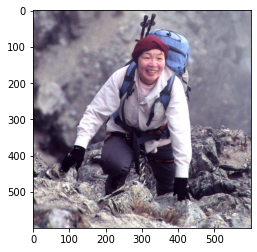

In [261]:
image, label = train_Dataset[25]
plt.imshow(image)
print(label)

In [262]:
a_transform = A.Compose(
    [
        A.Resize(width=512, height=512),
        A.RandomCrop(width=300, height=300),
        A.Rotate(limit=40, p=0.9, border_mode=cv2.BORDER_CONSTANT),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.9),
        A.OneOf([
            A.Blur(blur_limit=3, p=0.5),
            A.ColorJitter(p=0.5),
        ], p=1.0),
        A.Normalize(
            mean=[0, 0, 0],
            std=[1, 1, 1],
            max_pixel_value=255,
        ),
#         ToTensorV2(),
    ]
)


In [263]:
train_Dataset = ImageFolder("../input/famous-iconic-women/output/train",total_classes=2, transform=a_transform )
test_Dataset = ImageFolder("../input/famous-iconic-women/output/valid",total_classes=2, transform=a_transform )

<class 'torch.Tensor'> torch.Size([300, 300, 3]) tensor(0)
torch.Size([300, 300, 3])


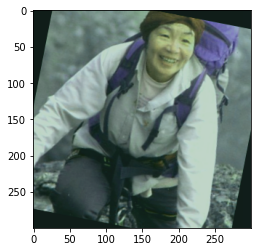

In [264]:
x, y  = train_Dataset[25]
print(x.shape)

plt.imshow(x)

In [265]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [266]:
model = models.resnet18(pretrained=True).to(device=device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [267]:
model.fc = nn.Linear(in_features=512, out_features=2, bias=True)

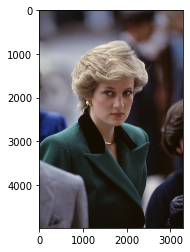

In [268]:
img = Image.open("../input/famous-iconic-women/output/train/Diana, Princess of Wales/000003.jpg")
plt.imshow(img)

In [269]:
img.size

(3298, 4982)

In [270]:
x.unsqueeze(1).permute(1,0,2,3).shape

torch.Size([1, 300, 300, 3])

In [271]:
y = model(x.unsqueeze(0).permute(0,3,1,2).to(device=device))
y.shape

torch.Size([1, 2])

In [272]:
train_Dataset.__len__()

84

In [273]:
in_channels = 3
num_classes = 10
learning_rate = 1e-3
batch_size = 64
num_epochs = 3

In [274]:
train_dataloader = DataLoader(dataset=train_Dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset=test_Dataset, batch_size=batch_size)


In [275]:
loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)



In [276]:
for epoch in range(num_epochs):
    for data, target in train_dataloader:
        data = data.permute(1,0,2,3).to(device=device)
        target = target.to(device=device)
        
        print(data.shape)
        
        score = model(data)
        loss = loss_criterion(score, target)
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
    
    print(f"epoch : {epoch} , loss: {loss}")
        
    

ValueError: could not broadcast input array from shape (300,1) into shape (300)

In [277]:
def check_accuracy(mode, loader):
    model.eval()
    
    total_correct = 0
    total_prediction = 0
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            
            score = model(x)
            
            _,predictions = score.max()
            
            total_correct += (predictions==y).sum()
            total_prediction += predictions.shape[0]
    
    print(f"accuracy: {(total_correct/total_prediction)*100}")
            
            

In [ ]:
check_accuracy(model,test_dataloader)
check_accuracy(model,train_dataloader)